# Application of Deep Learning on Cancer Images
### 1000-719bMSB MIM UW, Neo Christopher Chung

In this lab, we make a prediction of lung nodules by a deep learning model and explain that decision making process by attention maps and CDAMs. For the simplicity, we provide a pre-trained model and use an existing medical image dataset. To streamline XAI, we are using a Python library called Obz. 

In [41]:
import sys
import os

# Repository root directory
repo_root = os.path.abspath(os.path.join(os.getcwd(), ".."))
sys.path.append(repo_root)
print(repo_root)

/home/lambi/Desktop/studia/ModZlo


We will go through the scenario step by step. Firstly, let's start with doing some imports.

In [42]:
# uv pip install torch torchvision torchmetrics
from torch.utils.data import DataLoader
from torchvision.transforms import v2
import torch
from torch import nn
import numpy as np
import gdown
import os
import matplotlib.pyplot as plt

**Obz package** is designed to monitor your vision models behaviour. In particular it logs *post hoc* explainability maps and might detect outliers. However, first of all you need to define your model which you would like to monitor.  
So, let's define a simple Vision Transformer based on DINO ViT Backbone! Especially for you I have finetuned DINO VIT model on *LIDC-IDRI* dataset. We will utilize it for a tutorial!

In [43]:
## Install Obz
# pip install "git+https://github.com/obzai/obz"
# uv pip install "git+https://github.com/obzai/obz"

def download_weights(url, output_dir, filename):
    """
    Downloads weights from the given URL if they are not already downloaded.
    """
    os.makedirs(output_dir, exist_ok=True)
    output_path = os.path.join(output_dir, filename)
    
    if not os.path.exists(output_path):
        print(f"Downloading weights to {output_path}...")
        gdown.download(url, output_path)
    else:
        print(f"Weights already exist at {output_path}. Skipping download.")

url = "https://drive.google.com/uc?id=1xUevCbvII5yXDxVxb7bR65CPmgz2sGQA"
output_dir = "tuned_models"
filename = "lidc_dino_s8.pth"
download_weights(url, output_dir, filename)

Weights already exist at tuned_models/lidc_dino_s8.pth. Skipping download.


In [44]:
from transformers import ViTConfig, ViTModel

class DINO(nn.Module):
    """
    DINO Transformer model based on Huggingface implementation.
    """
    def __init__(self):
        super().__init__()
        # Backbone
        config = ViTConfig.from_pretrained('facebook/dino-vits8', attn_implementation="eager") # We propose eager implementation to return att scores gracefully.
        self.backbone = ViTModel(config)
        # Classfication head
        self.head = torch.nn.Linear(384, 1)
    
    def forward(self, x: torch.Tensor, output_attentions:bool=False):
        out = self.backbone(x, output_attentions=output_attentions)
        x = out["pooler_output"]
        x = self.head(x)
        if output_attentions:
            att = out["attentions"]
            return x, att
        else:
            return x

In [45]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
WEIGHTS_PATH = "./tuned_models/lidc_dino_s8.pth"

MODEL = DINO()
MODEL.load_state_dict(torch.load(WEIGHTS_PATH, weights_only=True, map_location=torch.device(DEVICE)))
MODEL = MODEL.to(DEVICE).eval()

Next, let's prepare datasets. You need two source of images! One is **Reference** dataset, which will be used to extract reference image features and fit outlier detection utilities. Second one, **Inference** dataset will act as incoming new data which uou would like to monitor.  
For the tutorial case we will use LIDC-IDRI subset called: **Nodule MNIST**. This dataset is readily available via **MedMNIST** package. If you don't have MedMNIST, please install it with a command below.

In [46]:
# Install medmnist package if you don't have already
#pip install medmnist

# from medmnist import NoduleMNIST3D
from medmnist import PathMNIST

In [57]:
# Transforms
# def take_middle_slice(inpt: np.ndarray):
#     """
#     NoduleMNIST 3D contains whole nodule volumes, however for this tutorial
#     we will utilize only central slice of each example.
#     We repeat this slice 3 times, as model expects input to have 3 channels.
#     """
#     inpt = inpt.squeeze()
#     X, Y, Z = inpt.shape
#     slice_ = inpt[:, :, Z//2]
#     slice_ = torch.Tensor(slice_).unsqueeze(dim=0).repeat(3,1,1)
#     return slice_


TRANSFORMS = v2.Compose([
    v2.Resize(size=(224, 224)),
    v2.ToTensor() 
])


NORMALIZE = v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

# Datasets
data_dir = "./example_data"
os.makedirs(data_dir, exist_ok=True)

## for homework, download a training set and train ViT models
train_set = PathMNIST(root=data_dir, split="train", transform=TRANSFORMS, download=True)
## Reference data. We will use it as source of reference statistics and to "train" OutlierDetector.
ref_set   = PathMNIST(root=data_dir, split="val", transform=TRANSFORMS, download=True)
## Inference data. We will use it as exemplary source of production data. 
inf_set   = PathMNIST(root=data_dir, split="test", transform=TRANSFORMS)

# DataLoaders
ref_loader = DataLoader(ref_set, batch_size=32, shuffle=False)
inf_loader = DataLoader(inf_set, batch_size=6, shuffle=True)

# Labels mapping
from medmnist.info import INFO
CLASS_NAMES = [INFO["pathmnist"]["label"][str(i)] for i in range(9)]
LOGIT2NAME = {i: CLASS_NAMES[i] for i in range(len(CLASS_NAMES))}



Using downloaded and verified file: ./example_data/pathmnist.npz
Using downloaded and verified file: ./example_data/pathmnist.npz


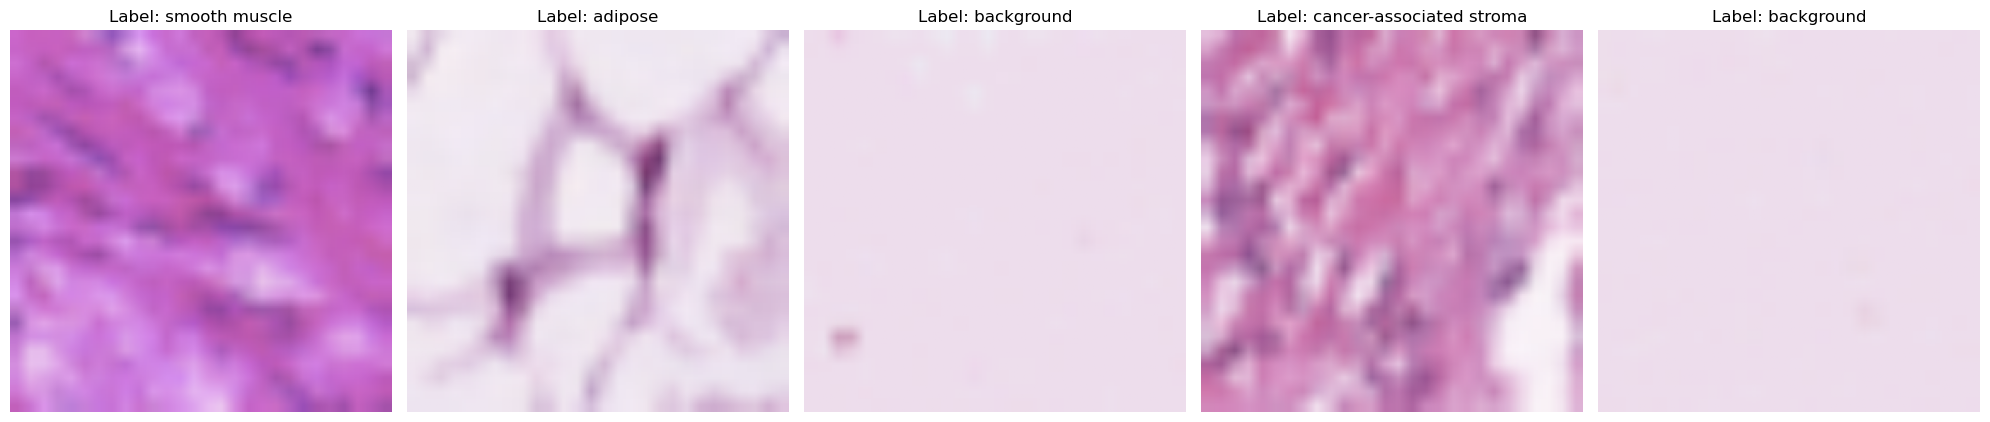

In [58]:
# Visualize the first 5 samples from ref_loader
samples, labels = next(iter(ref_loader))

# Plot the first 10 samples
fig, axes = plt.subplots(1, 5, figsize=(20, 5))
for i in range(5):
    image = samples[i].permute(1, 2, 0).numpy()  # Convert tensor to numpy array and rearrange dimensions
    axes[i].imshow(image, cmap='gray')
    axes[i].set_title(f"Label: {CLASS_NAMES[labels[i].item()]}")
    axes[i].axis('off')

plt.tight_layout()
plt.show()

Make the prediction for those 5 samples using the aforementioned MODEL

In [60]:
# Move samples to the appropriate device
samples = samples[:5].to(DEVICE)
labels = labels[:5].to(DEVICE)
print(labels)
print(samples.shape)

# Normalize the samples
samples = NORMALIZE(samples)

# Perform inference using the model
with torch.no_grad():
    logits = MODEL(samples)
    predictions = torch.argmax(logits, dim=1).cpu().numpy()

# Map predictions to class names
predicted_classes = [LOGIT2NAME[int(pred)] for pred in predictions]

# Print the results
for i, pred_class in enumerate(predicted_classes):
    print(f"Prediction for Sample {i + 1}: {pred_class}")


tensor([[5],
        [0],
        [1],
        [7],
        [1]])
torch.Size([5, 3, 224, 224])
Prediction for Sample 1: adipose
Prediction for Sample 2: adipose
Prediction for Sample 3: adipose
Prediction for Sample 4: adipose
Prediction for Sample 5: adipose


## Extract features for outlier detection

You can use Data Inspector Module and XAI Module locally to detect outliers and compute explainability maps.
You need to instantiate `OutlierDetector` from Data Inspector Module and desired `XAI Tools` from XAI Module.

In [61]:
#### When loading Obz, you may need to do:
from obzai.data_inspector.extractor import FirstOrderExtractor

# Setup OutlierDetector
# from data_inspector.extractor import FirstOrderExtractor
from obzai.data_inspector.detector import GMMDetector
# Choose desired feature extractor. Chosen extractor will be used for monitoring.
first_order_extrc = FirstOrderExtractor()

# Pass choosen extractor(s) to chosen OutlierDetector. Below we utilize outlier detector based on Gaussian Mixture Models.
gmm_detector = GMMDetector(extractors=first_order_extrc, n_components=3, outlier_quantile=0.01)
# Call .fit() method with passed reference dataloader. 
# Method will extract desired image features and fit outlier detection model (in that case GMM).
gmm_detector.fit(ref_loader)


## Explain the AI model

#### We first need to choose and set up appropriate XAI tools.

In [64]:
# Setup XAI Tools
from obzai.xai.xai_tool import CDAM, AttentionMap
#from xai.xai_tool import CDAM, AttentionMap

# Choose desired XAI Tools
cdam_tool = CDAM(model=MODEL, 
                 mode='vanilla',                      # CDAM mode
                 gradient_type="from_logits",  # Whether backpropagate gradients from logits or probabilities.
                 gradient_reduction="average",        # Gradient reduction method.
                 activation_type="sigmoid")           # Activation function applied on logits. (Needed when gradients are backpropagated from probabilities.)
# In CDAM you need to specify on which layer you want to create hooks.
cdam_tool.create_hooks(layer_name="backbone.encoder.layer.0.layernorm_before")

attention_tool = AttentionMap(model=MODEL,
                              attention_layer_id = -1,# ID of an attention layer from which to extract attention weights
                              head = None             # ID of attention head to choose. If None, attention scores are averaged.
                              )


#### Then, we can run the XAI method to our data.
We first apply and visualize attention maps

In [65]:
# Apply attention_tool on the first ten samples
attention_maps = attention_tool.explain(samples)  # Use the appropriate method to generate attention maps

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-6.356192..8.844406].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-6.590661..9.154259].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [1.3812779..8.92187].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-5.1056914..9.464111].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [5.28909..8.612018].


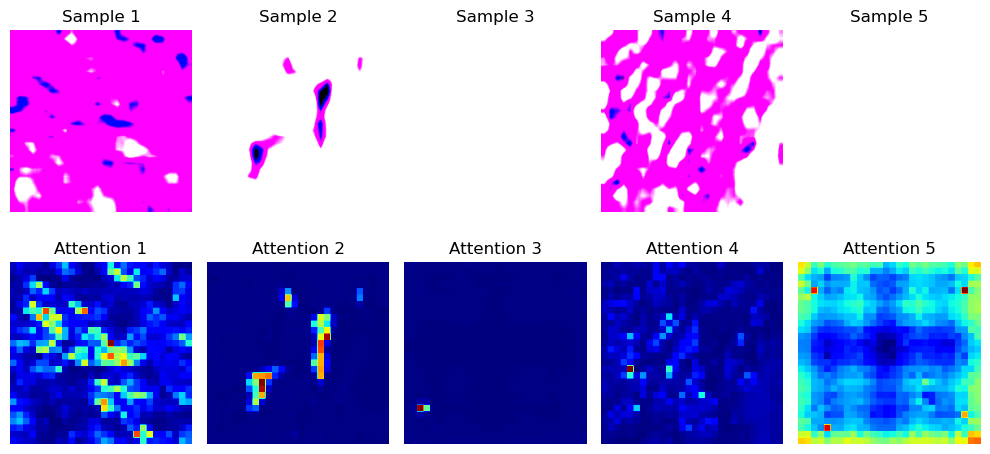

In [66]:
# Visualize samples and attention maps
fig, axes = plt.subplots(2, 5, figsize=(10, 5))

# First row: Original samples
for i in range(5):
    original_image = samples[i].permute(1, 2, 0).cpu().numpy()  # Convert tensor to numpy array and rearrange dimensions
    axes[0, i].imshow(original_image, cmap='gray')
    axes[0, i].set_title(f"Sample {i + 1}")
    axes[0, i].axis('off')

# Second row: Attention maps
for i in range(5):
    attention_map = attention_maps[i].cpu().numpy()
    axes[1, i].imshow(attention_map, cmap='jet')
    axes[1, i].set_title(f"Attention {i + 1}")
    axes[1, i].axis('off')

plt.tight_layout()
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-6.356192..8.844406].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-6.590661..9.154259].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [1.3812779..8.92187].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-5.1056914..9.464111].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [5.28909..8.612018].


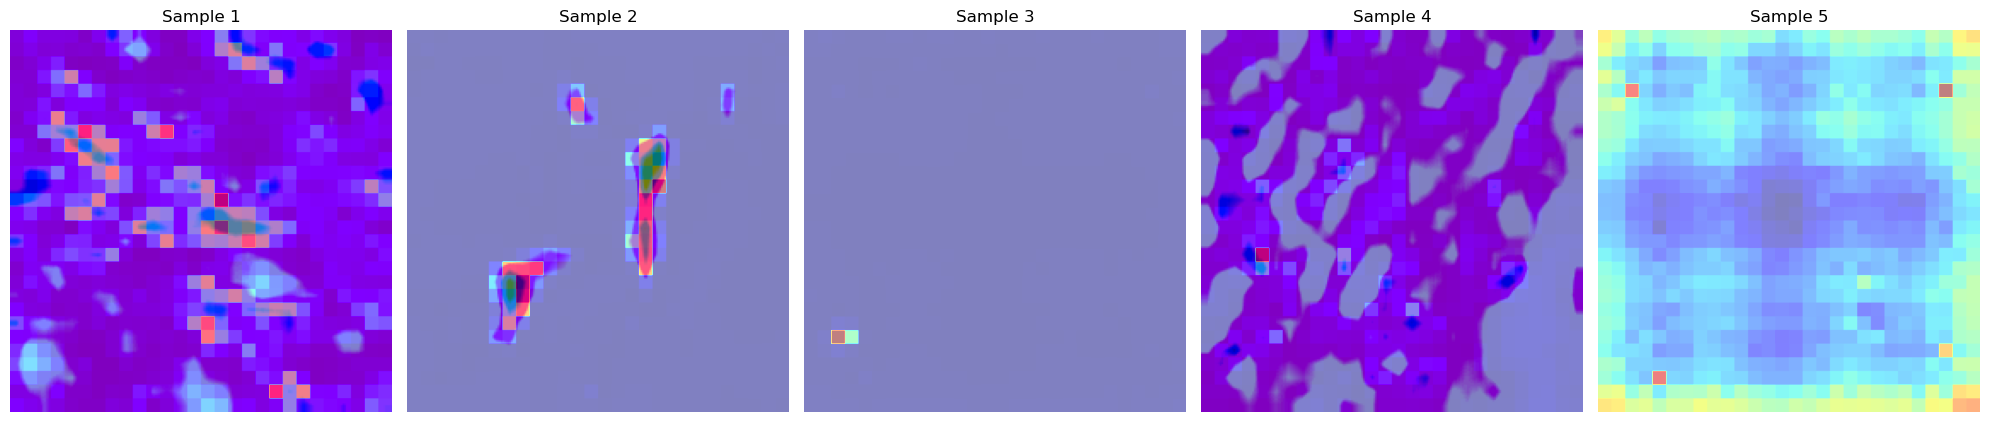

In [67]:
# Visualize attention maps overlaid on samples
fig, axes = plt.subplots(1, 5, figsize=(20, 5))

for i in range(5):
    original_image = samples[i].permute(1, 2, 0).cpu().numpy()  # Convert tensor to numpy array and rearrange dimensions
    attention_map = attention_maps[i].cpu().numpy()  # Convert attention map to numpy array

    # Overlay attention map on the original image
    axes[i].imshow(original_image, cmap='gray')
    axes[i].imshow(attention_map, cmap='jet', alpha=0.5)  # Use alpha for transparency
    axes[i].set_title(f"Sample {i + 1}")
    axes[i].axis('off')

plt.tight_layout()
plt.show()

#### Generate and visualize CDAM maps

In [69]:
# Generate CDAM maps
cdam_maps = cdam_tool.explain(samples, target_idx=[0,0,0,0,0])  # Use the appropriate method to generate CDAM maps

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-6.356192..8.844406].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-6.590661..9.154259].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [1.3812779..8.92187].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-5.1056914..9.464111].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [5.28909..8.612018].


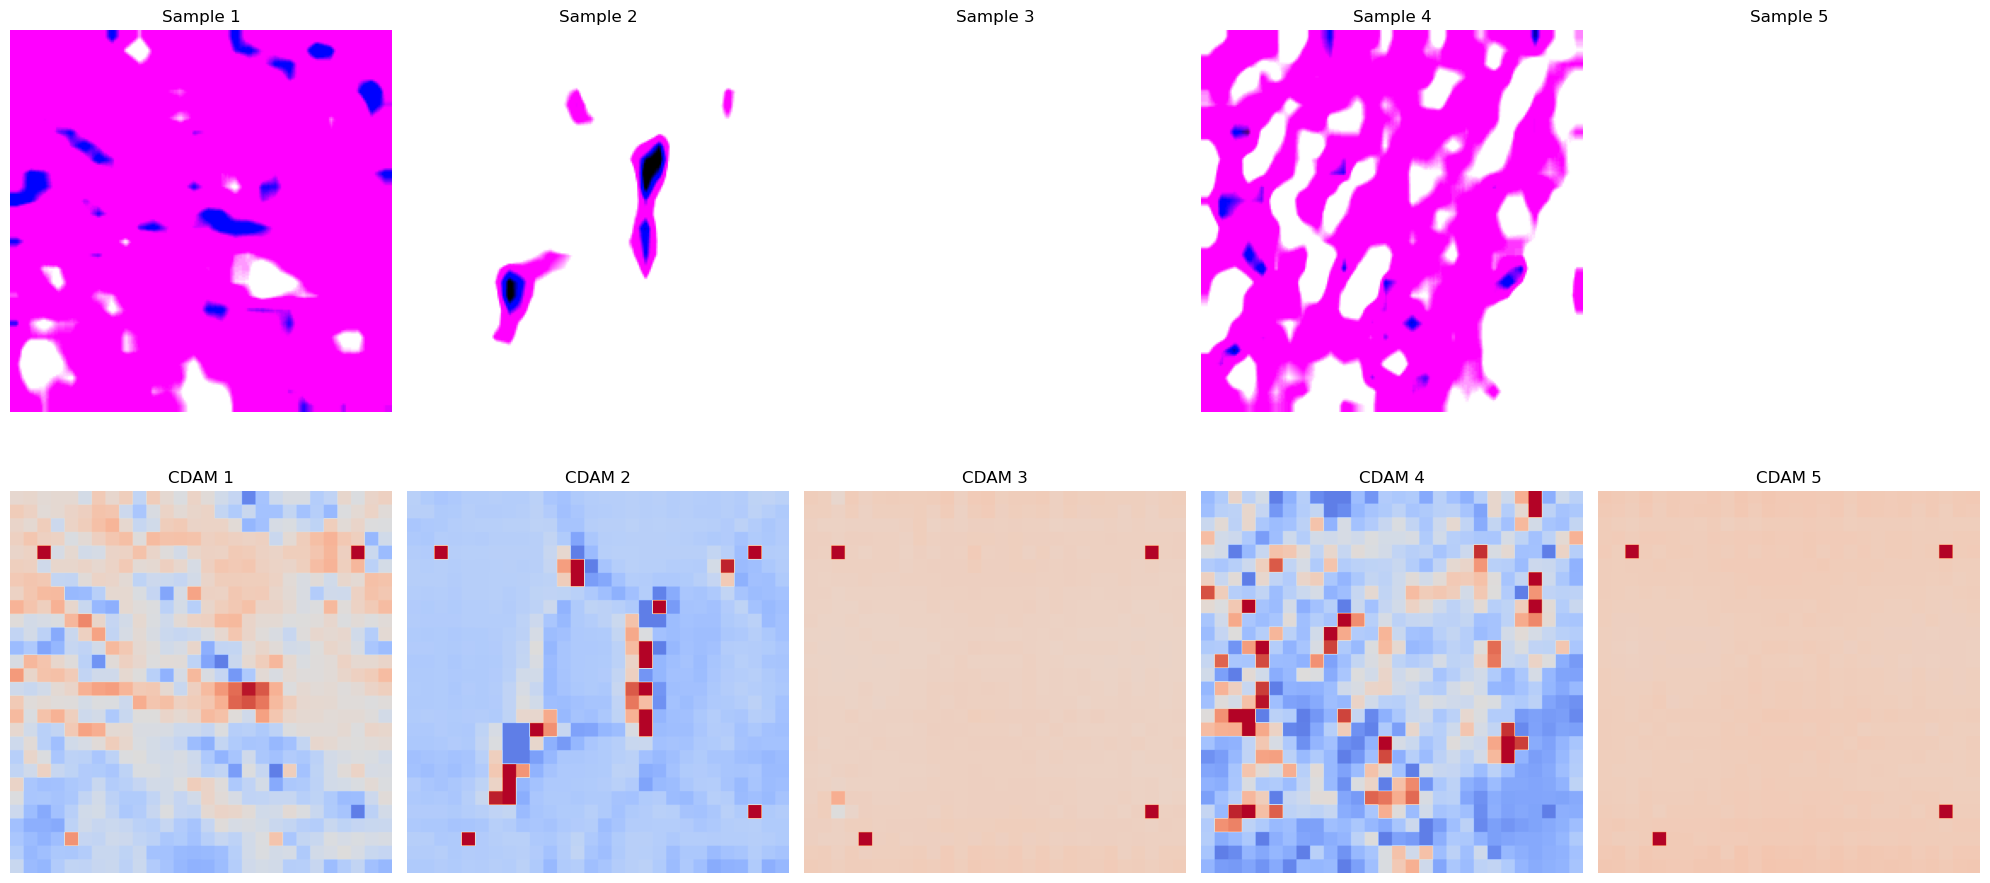

In [70]:
# Visualize samples and CDAM maps
fig, axes = plt.subplots(2, 5, figsize=(20, 10))

# First row: Original samples
for i in range(5):
    original_image = samples[i].permute(1, 2, 0).cpu().numpy()  # Convert tensor to numpy array and rearrange dimensions
    axes[0, i].imshow(original_image, cmap='gray')
    axes[0, i].set_title(f"Sample {i + 1}")
    axes[0, i].axis('off')

# Second row: CDAM maps
for i in range(5):
    cdam_map = cdam_maps[i].squeeze().cpu().numpy()  # Convert CDAM map to numpy array
    axes[1, i].imshow(cdam_map, cmap='coolwarm', vmin=-cdam_maps.abs().max(), vmax=cdam_maps.abs().max())  # Diverging colormap
    axes[1, i].set_title(f"CDAM {i + 1}")
    axes[1, i].axis('off')

plt.tight_layout()
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-6.356192..8.844406].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-6.590661..9.154259].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [1.3812779..8.92187].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-5.1056914..9.464111].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [5.28909..8.612018].


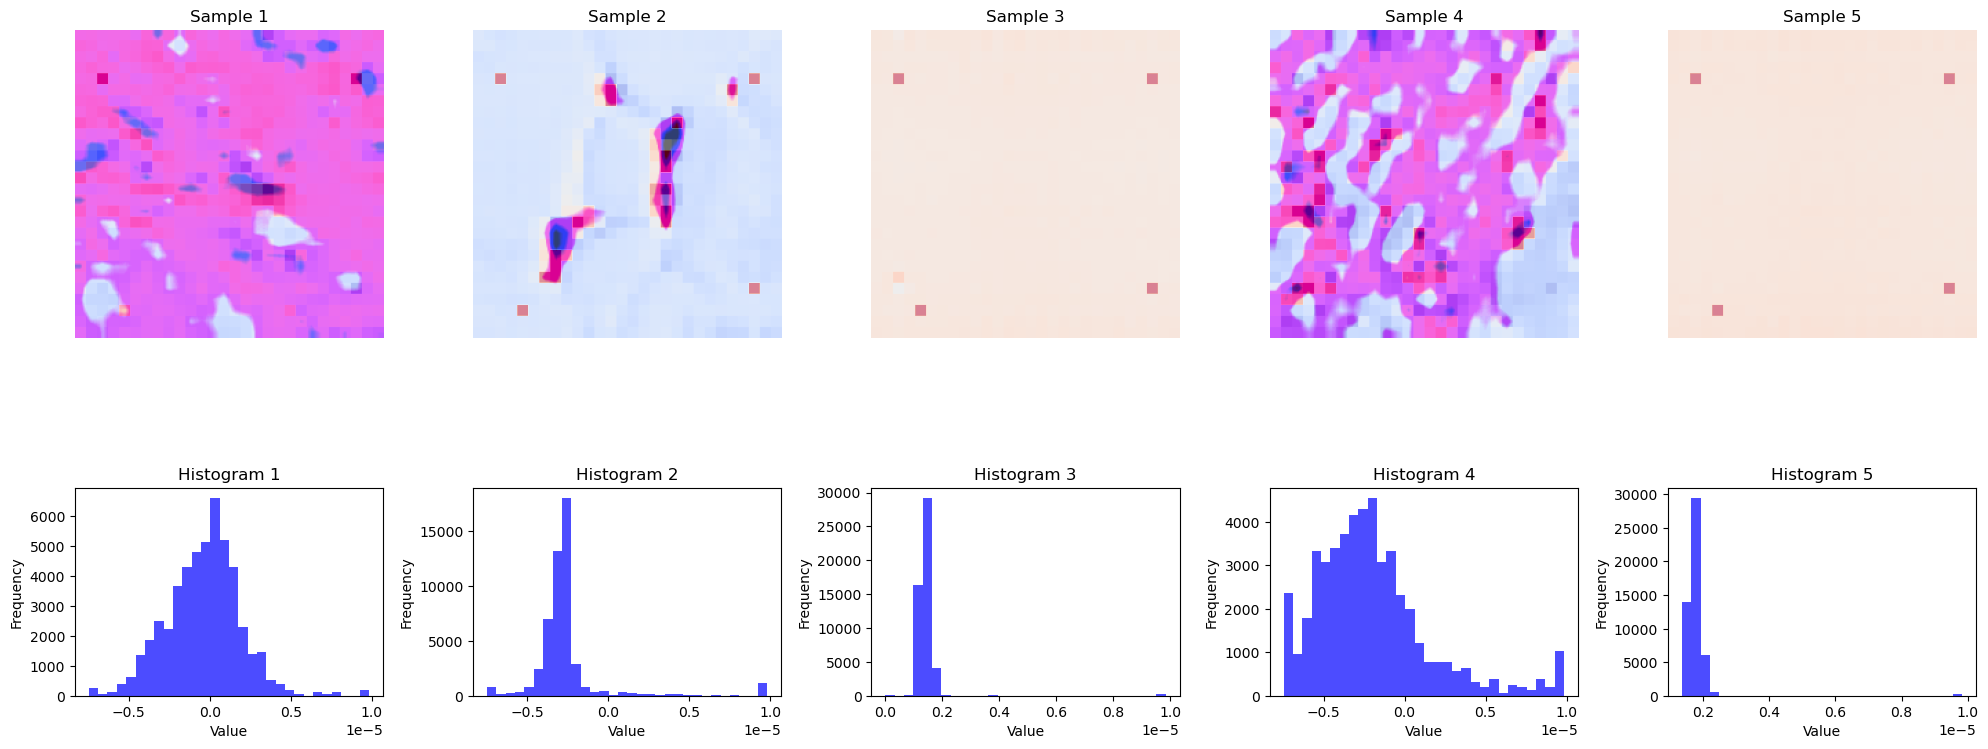

In [71]:
# Visualize CDAM maps overlaid on samples with histogram and color bar
fig, axes = plt.subplots(2, 5, figsize=(20, 10), gridspec_kw={'height_ratios': [4, 1]})

# First row: Original samples with overlaid CDAM maps
for i in range(5):
    original_image = samples[i].permute(1, 2, 0).cpu().numpy()  # Convert tensor to numpy array and rearrange dimensions
    cdam_map = cdam_maps[i].squeeze().cpu().numpy()  # Convert CDAM map to numpy array

    # Overlay CDAM map on the original image
    im = axes[0, i].imshow(original_image, cmap='gray')
    im = axes[0, i].imshow(cdam_map, cmap='coolwarm', alpha=0.5, vmin=-cdam_maps.abs().max(), vmax=cdam_maps.abs().max())  # Use alpha for transparency
    axes[0, i].set_title(f"Sample {i + 1}")
    axes[0, i].axis('off')

# Second row: Histogram of CDAM map values
for i in range(5):
    cdam_map = cdam_maps[i].squeeze().cpu().numpy()  # Convert CDAM map to numpy array
    axes[1, i].hist(cdam_map.ravel(), bins=30, color='blue', alpha=0.7)
    axes[1, i].set_title(f"Histogram {i + 1}")
    axes[1, i].set_xlabel('Value')
    axes[1, i].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

## Homework (for 2 weeks)

Train a Vision Transformer model on any of MedMNIST datasets (except NoduleMNIST), followed by prediction and explanation.

Essentially apply the above steps with a different ViT model trained on one of the MedMNIST datasets.

